In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/home/hm/anaconda3/envs/drlnd/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import json
import pathlib
import collections
import itertools

import pandas as pd
import plotnine as p9

In [3]:
tuning_results_dir = pathlib.Path('../training_output/tuning_ddpg')

In [35]:
resources_dir = pathlib.Path("../training_output/tuning_results")
resources_dir.mkdir(exist_ok=True, parents=True)

In [4]:
expected_filenames = {
    'metadata.json', 
    'training_params.json',  
    'weights_critic.pth',
    'scores.csv',     
    'weights_actor.pth'
}

In [5]:
agent_dirs = [
    d for d in tuning_results_dir.glob("*") 
    if set([p.name for p in d.glob("*")]) == expected_filenames 
]
agent_dirs

[PosixPath('../training_output/tuning_ddpg/a1bf22ca-d227-4737-b082-11717ba759e5'),
 PosixPath('../training_output/tuning_ddpg/b67eb3ad-35da-4eb6-b153-3b481bc92d93'),
 PosixPath('../training_output/tuning_ddpg/52ed0ce7-9dbe-4ea1-b86f-dc2f171d5e99'),
 PosixPath('../training_output/tuning_ddpg/c98f3dc7-f936-48d7-b442-50d868e09fdc'),
 PosixPath('../training_output/tuning_ddpg/7262f3bf-2a98-482c-91a8-87c72f19bb36'),
 PosixPath('../training_output/tuning_ddpg/56bcd621-dfa6-4bc2-b2f5-f2e76cc2a9a3'),
 PosixPath('../training_output/tuning_ddpg/9c5b7f31-5ff9-438a-abf3-38df3ac9d72e'),
 PosixPath('../training_output/tuning_ddpg/ba54d653-45af-4f4e-8c3c-af3efa6ee9df'),
 PosixPath('../training_output/tuning_ddpg/01fd37de-113c-4bb8-8b2a-15ea47f2d344'),
 PosixPath('../training_output/tuning_ddpg/5644cd9d-e6fd-4316-b0d0-3001e0e5f1e9'),
 PosixPath('../training_output/tuning_ddpg/f3ada71f-8663-476f-a40c-83113947e076'),
 PosixPath('../training_output/tuning_ddpg/238f0558-5546-4260-883f-a4317f88bdb5')]

In [6]:
agent_results = []
for i, p in enumerate(agent_dirs):
    with open(p.joinpath('training_params.json')) as f:
        training_params = json.load(f)
    df_scores = pd.read_csv(p.joinpath('scores.csv'), index_col=None)
    df_scores['agent_id'] = i
    r = (training_params, df_scores)
    agent_results.append(r)

In [7]:
df_scores = pd.concat([df for _, df in agent_results])
df_scores['agent_id'] = df_scores['agent_id'].astype(str)
df_scores = df_scores.loc[df_scores['episode'] <= 200, :]
df_scores

,episode,score,agent_id
0,1,0.165500,0
1,2,0.477000,0
2,3,0.825000,0
3,4,0.638500,0
4,5,0.713500,0
...,...,...,...
145,146,37.378999,11
146,147,36.804999,11
147,148,35.320999,11
148,149,36.796999,11


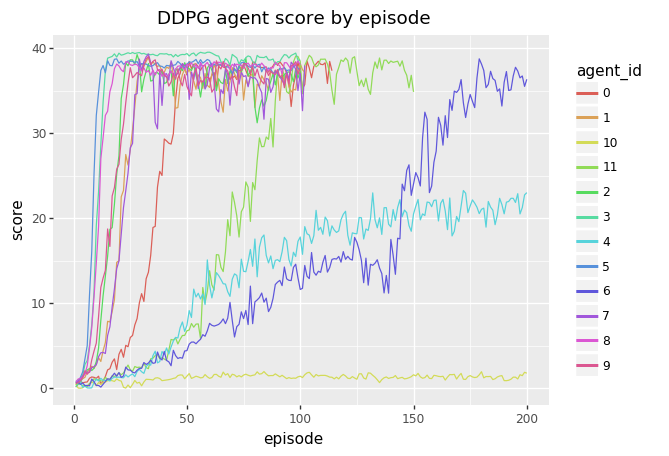

<ggplot: (-9223363287822450807)>

In [30]:
scores_plot = p9.ggplot(data=df_scores, mapping=p9.aes(x="episode", y="score", group="agent_id", color='agent_id')) + p9.geom_line()
scores_plot += p9.ggtitle("DDPG agent score by episode")
scores_plot

In [36]:
scores_plot.save(str(resources_dir.joinpath("scores_all.png")))

In [ ]:
c = collections.Counter(itertools.chain.from_iterable(r[0].items() for r in agent_results))

In [20]:
common_params = dict((k for k, v in c.items() if v == len(agent_results)))
common_params

{'n_episodes': 500,
 'mean_score_threshold': 30.0,
 'max_t': 1000,
 'learning_rate_actor': 0.002,
 'learning_rate_critic': 0.001,
 'tau_soft_update': 0.001,
 'l2_weight_decay': 0,
 'has_ou_noise': True,
 'ou_noise_mu': 0.0,
 'ou_noise_theta': 0.15,
 'agent_seed': 11111,
 'logging_freq': 1}

In [26]:
df_common_params = pd.DataFrame.from_records(list(common_params.items()), columns=['parameter', 'value'])
df_common_params

,parameter,value
0,n_episodes,500
1,mean_score_threshold,30
2,max_t,1000
3,learning_rate_actor,0.002
4,learning_rate_critic,0.001
5,tau_soft_update,0.001
6,l2_weight_decay,0
7,has_ou_noise,True
8,ou_noise_mu,0
9,ou_noise_theta,0.15


In [37]:
df_common_params.to_csv(resources_dir.joinpath("common_hyperparams.csv"), index=False)

In [21]:
varying_param_names = sorted(set((k[0] for k, v in c.items() if v != len(agent_results) and k[0] != 'agent_seed')))
varying_param_names

['batch_size',
 'buffer_size',
 'gamma_discount_factor',
 'num_updates',
 'ou_noise_sigma',
 'update_every']

In [9]:
columns = ['agent_id'] + varying_param_names + ['n_episodes_to_solve']
rows = [
    tuple([str(i)] + [tp[p] for p in varying_param_names] + [df.shape[0] - 100]) 
    for i, (tp, df) in enumerate(agent_results)
]
df_agent_params = pd.DataFrame.from_records(rows, index=None, columns=columns)
df_agent_params

,agent_id,batch_size,buffer_size,gamma_discount_factor,num_updates,ou_noise_sigma,update_every,n_episodes_to_solve
0,0,128,100000,0.99,20,0.2,10,14
1,1,128,100000,0.95,20,0.2,10,2
2,2,128,100000,0.95,20,0.1,10,0
3,3,1024,1000000,0.95,20,0.1,10,0
4,4,128,100000,0.99,10,0.2,20,400
5,5,1024,1000000,0.95,20,0.2,10,0
6,6,128,100000,0.99,10,0.1,20,126
7,7,128,100000,0.95,20,0.1,10,2
8,8,1024,1000000,0.99,20,0.2,10,0
9,9,128,100000,0.99,20,0.1,10,0


In [38]:
df_agent_params.to_csv(resources_dir.joinpath("agent_hyperparams.csv"), index=False)

In [17]:
df_best_agents = df_agent_params.loc[df_agent_params['n_episodes_to_solve'] < 10, :]
df_best_agents

,agent_id,batch_size,buffer_size,gamma_discount_factor,num_updates,ou_noise_sigma,update_every,n_episodes_to_solve
1,1,128,100000,0.95,20,0.2,10,2
2,2,128,100000,0.95,20,0.1,10,0
3,3,1024,1000000,0.95,20,0.1,10,0
5,5,1024,1000000,0.95,20,0.2,10,0
7,7,128,100000,0.95,20,0.1,10,2
8,8,1024,1000000,0.99,20,0.2,10,0
9,9,128,100000,0.99,20,0.1,10,0


In [39]:
df_best_agents.to_csv(resources_dir.joinpath("best_agents_hyperparams.csv"), index=False)

In [11]:
df_best_agent_ids = set(df_best_agents['agent_id'])
df_best_agent_ids

{'1', '2', '3', '5', '7', '8', '9'}

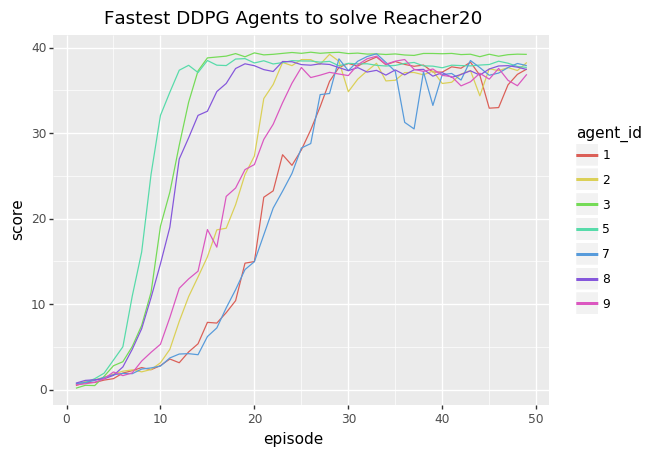

<ggplot: (8749037548762)>

In [18]:
df_best_scores = df_scores.loc[df_scores['agent_id'].isin(df_best_agent_ids) & (df_scores['episode'] < 50), :]
best_scores_plot = p9.ggplot(data=df_best_scores, mapping=p9.aes(x="episode", y="score", group="agent_id", color='agent_id')) + p9.geom_line()
best_scores_plot += p9.ggtitle('Fastest DDPG Agents to solve Reacher20')
best_scores_plot

In [41]:
best_scores_plot.save(str(resources_dir.joinpath("scores_best.png")))